<a href="https://colab.research.google.com/github/Frosk-Kristian/COMP6002-Group10-Models/blob/main/COMP6002_Group_Project_ML_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP6002 Computer Science Project - Group 10
Utilising Machine Learning to detect DDoS attacks.

## Reference
Iman Sharafaldin, Arash Habibi Lashkari, Saqib Hakak, and Ali A. Ghorbani, "Developing Realistic Distributed Denial of Service (DDoS) Attack Dataset and Taxonomy", IEEE 53rd International Carnahan Conference on Security Technology, Chennai, India, 2019.

# Setup
Run all of these first. Sets up libraries and directories used throughout notebook.

In [1]:
import pandas as pd
print(f"Using Pandas version: {pd.__version__}")

Using Pandas version: 2.0.3


In [2]:
import numpy as np
print(f"Using Numpy version: {np.__version__}")

Using Numpy version: 1.25.2


In [3]:
from sklearn import __version__ as skl_ver
print(f"Using Sklearn version: {skl_ver}")

Using Sklearn version: 1.2.2


In [4]:
!pip install imblearn

from imblearn import __version__ as imb_ver
print(f"Using Imbalanced learn version: {imb_ver}")

Using Imbalanced learn version: 0.10.1


In [5]:
!pip install codecarbon

from codecarbon import __version__ as cc_ver
print(f"Using CodeCarbon.io version: {cc_ver}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.6/174.6 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 18.5 MB/s eta 0:00:00
Using CodeCarbon.io version: 2.3.5


In [6]:
import os
from google.colab import drive

# mounts google drive
drive.mount("/content/drive")

# directory that project related files are stored in
dl_dir = os.getcwd() + r'/drive/MyDrive/Colab Notebooks/COMP6002_Group10_Data'
# directory that exports are saved in
save_dir = dl_dir + f"/Exports_{pd.Timestamp.today(tz='Australia/Perth').strftime('%d-%m-%Y')}"
# directory that the runtime will store the unzipped dataset in (not on your drive)
data_dir = os.getcwd() + '/dataset'

# checks if export directory already exists, if not creates it
if os.path.exists(dl_dir):
  print(f"Directory {dl_dir} already exists.\n")
else:
  os.mkdir(dl_dir)
  print(f"Successfully created the directory {dl_dir}")

# checks if saves directory already exists, if not creates it
if os.path.exists(save_dir):
  print(f"Directory {save_dir} already exists.\n")
else:
  os.mkdir(save_dir)
  print(f"Successfully created the directory {save_dir}")

Mounted at /content/drive
Directory /content/drive/MyDrive/Colab Notebooks/COMP6002_Group10_Data already exists.

Successfully created the directory /content/drive/MyDrive/Colab Notebooks/COMP6002_Group10_Data/Exports_09-05-2024


## Instance Details
Gets hardware specifications and region details of the Google Colab instance.

In [7]:
# CPU specifications
from psutil import *

!cat /proc/cpuinfo | grep "model name" | head -1

print(f"Number of CPU: {cpu_count()}")
!cat /proc/cpuinfo

model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
Number of CPU: 2
processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed
bog

In [8]:
# VRAM specifications
virtual_memory()

svmem(total=13609447424, available=12186562560, percent=10.5, used=1112772608, free=8058716160, active=689549312, inactive=4595671040, buffers=354705408, cached=4083253248, shared=2658304, slab=159563776)

In [9]:
# GPU specifications
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [10]:
# Server information
!curl ipinfo.io

{
  "ip": "34.132.118.11",
  "hostname": "11.118.132.34.bc.googleusercontent.com",
  "city": "Council Bluffs",
  "region": "Iowa",
  "country": "US",
  "loc": "41.2619,-95.8608",
  "org": "AS396982 Google LLC",
  "postal": "51502",
  "timezone": "America/Chicago",
  "readme": "https://ipinfo.io/missingauth"
}

## Define Helper Functions

In [11]:
# helper functions for exporting/importing models trained with Sklearn, use the NN specific functions when saving/loading the neural network
# all functions defined will prompt the user for confirmation unless skip_prompt is True, to allow for skipping the functions when running the notebook
import joblib
import pickle

print(f"Using Joblib version: {joblib.__version__}")
print(f"Using Pickle version: {pickle.format_version}")

# function used to append a number to a filename in the event that the file already exists
def IncrementFname(file_path):
  """
  Takes a file path, splits the file name/extension and inserts an incrementing integer between them until a unique name is found.

  Parameters:
    file_path (string): full file path to increment, including extension.
  Returns:
    string: new file name in the form of 'path/to/file(i).extension'.
  """
  fname, ext = os.path.splitext(file_path)
  i = 1
  new_name = f'{fname}({i}){ext}' # intial reassignment

  # if filename(1).extension already exists, increment number until an unused one is found
  while os.path.exists(new_name):
    i += 1
    new_name = f'{fname}({i}){ext}'

  return new_name

# Save a trained model to the provided filepath
def SaveToFile(save_data, save_fpath, skip_prompt = False):
  """
  Exports a object to a provided path using joblib, with or without prompting user for confirmation.

  Parameters:
    save_data (object): object to be saved.
    save_fpath (string): file path that the object will be saved in, including filename and extension.
    skip_prompt (boolean): if True, skips prompting user for confirmation before saving.
  Returns:
    : no value returned.
  """
  to_save = "y" if skip_prompt else ""

  # loops until 'y', 'Y', 'n', or 'N' have been entered by the user, returns early if 'n' or 'N' are entered.
  while to_save.lower() not in ('y', 'n'):
    to_save = input("Export to file? (y/n)\n")
    if to_save.lower() in 'y':
      print("Save confirmed.")
    elif to_save.lower() in 'n':
      print("Save cancelled.")
      return
    else:
      print("WARNING: please only enter \'y\' to confirm or \'n\' to cancel.")

  fpath = save_fpath # allows for reassignment
  if os.path.isfile(fpath):
    print(f"WARNING: file \'{fpath}\' already exists...")
    fpath = IncrementFname(fpath)
    print(f"...Saving to \'{fpath}\' instead.")

  try:
    joblib.dump(save_data, fpath)
  except:
    print(f"ERROR: an unknown error occured calling \'joblib.dump({save_data}, {fpath})\'!")
  else:
    print(f"SUCCESS: saved to \'{fpath}\'.")


# Load a trained model from the provided filepath
def LoadFromFile(load_fpath, skip_prompt = False):
  """
  Import a serialised object via joblib.

  Parameters:
    load_fpath (string): file path to stored object.
    skip_prompt (boolean): if True, skips prompting user for confirmation before loading.
  Returns:
    object: if a file is found and loaded correctly, returns the stored object.
    None: if a user enters 'n' to cancel, no matching file is found or an error occurs during loading, returns None.
  """
  to_load = "y" if skip_prompt else ""

  # loops until 'y', 'Y', 'n', or 'N' have been entered by the user, returns early if 'n' or 'N' are entered.
  while to_load.lower() not in ('y', 'n'):
    to_load = input("Do you wish to import from file? {y/n)\n")
    if to_load.lower() in 'y':
      print("Load confirmed.")
    elif to_load.lower() in 'n':
      print("Load cancelled.")
      return None
    else:
      print("WARNING: please only enter \'y\' to confirm or \'n\' to cancel.")

  load_data = None
  print(f"Attempting to load object from \'{load_fpath}\'...")
  try:
    load_data = joblib.load(load_fpath)
  except FileNotFoundError:
    print(f"ERROR: the file \'{load_fpath}\' does not exist!")
    return None
  except:
    print(f"ERROR: an unknown error occurred calling \'joblib.load{load_fpath}\'!")
    return None
  else:
    print(f"SUCCESS: loaded data from \'{load_fpath}\'.")

  return load_data


# save a neural network to file
def SaveNN(nn_save, nn_fpath, skip_prompt = False):
  """
  Exports a neural network to a provided path using pickle, with or without prompting user for confirmation.

  Parameters:
    nn_save (object): NeuralNetClassifier object to be saved.
    nn_fpath (string): file path that the neural network will be saved in, including filename and extension.
    skip_prompt (boolean): if True, skips prompting user for confirmation before saving.
  Returns:
    : no value returned.
  """
  to_save = "y" if skip_prompt else ""

  while to_save.lower() not in ('y', 'n'):
    to_save = input("Save neural network to file? (y/n)\n")
    if to_save.lower() in 'y':
      print("Save confirmed.")
    elif to_save.lower() in 'n':
      print("Save cancelled.")
      return
    else:
      print("WARNING: please only enter \'y\' to confirm or \'n\' to cancel.")

  fpath = nn_fpath # allows for reassignment
  if os.path.isfile(fpath):
    print(f"WARNING: file \'{fpath}\' already exists...")
    fpath = IncrementFname(fpath)
    print(f"...Saving to \'{fpath}\' instead.")

  try:
    with open(fpath, 'wb') as f:
      pickle.dump(nn_save, f)
  except:
    print("ERROR: an unknown error occurred calling \'pickle.dump(nn_save, f)\'!")
  else:
    print(f"SUCCESS: saved neural network to \'{fpath}\'.")


# read a neural network previously saved to file
def LoadNN(nn_fpath, skip_prompt = False):
  """
  Import a serialised Skorch NeuralNetwork via Pickle.

  Parameters:
    nn_fpath (string): file path to stored neural network.
    skip_prompt (boolean): if True, skips prompting user for confirmation before loading.
  Returns:
    object: if a file is found and loaded correctly, returns the stored Neural Network.
    None: if a user enters 'n' to cancel, no matching file is found or an error occurs during loading, returns None.
  """
  to_load = "y" if skip_prompt else ""

  # loops until 'y', 'Y', 'n', or 'N' have been entered by the user, returns early if 'n' or 'N' are entered.
  while to_load.lower() not in ('y', 'n'):
    to_load = input("Do you wish to import a trained neural network? {y/n)\n")
    if to_load.lower() in 'y':
      print("Load confirmed.")
    elif to_load.lower() in 'n':
      print("Load cancelled.")
      return None
    else:
      print("WARNING: please only enter \'y\' to confirm or \'n\' to cancel.")

  nn_load = None
  print(f"Attempting to load neural network from \'{nn_fpath}\'...")
  try:
    with open(nn_fpath, 'rb') as f:
      nn_load = pickle.load(f)
  except:
    print(f"ERROR: an unknown error occurred calling \'picle.load{nn_fpath}\'!")
    return None
  else:
    print(f"SUCCESS: loaded neural network from \'{nn_fpath}\'.")

  return nn_load

Using Joblib version: 1.4.2
Using Pickle version: 4.0


# Import Data
Checks current working directory for datasets, if datasets are missing downloads a [.zip archive mirror of the CiCDDoS2019 hosted on Kaggle](https://www.kaggle.com/datasets/kristianfrossos/cicddos2019/data).

**NOTE:** the first part of this section is specific to Google Colab, and will not work outside of it. Advise writing an alternative later for local use (relevant when training Neural Network for speed and when usage limits get in the way).


In [ ]:
!pip -q install --upgrade --force-reinstall --no-deps kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.7/79.7 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
# sets up kaggle environment variables (needed to access API)
from google.colab import userdata
from google.colab import files

# checks if kaggle key and username have been provided as secrets and sets environment variables appropriately
# if not found, attempts to use kaggle.json
try:
  os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
  os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
  print("Using KAGGLE_KEY and KAGGLE_USERNAME defined in secrets.")
except (userdata.SecretNotFoundError, userdata.NotebookAccessError):
  print("WARN: One or more secret(s) missing or inaccessible.\n")
  if os.path.isfile('~/.kaggle/kaggle.json'):
    print("Using existing kaggle.json")
  else:
    print("Please upload kaggle.json")
    files.upload()

    if os.path.isfile(os.getcwd() + '/content/kaggle.json'):
      !rm -r ~/.kaggle
      !mkdir ~/.kaggle
      !mv ./kaggle.json ~/.kaggle/
      !chmod 600 ~/.kaggle/kaggle.json
    else:
      print("\'kaggle.json\' not uploaded.")
      raise

Using KAGGLE_KEY and KAGGLE_USERNAME defined in secrets.


In [ ]:
# checks if .zip archive containing dataset already exists in google drive and downloads it if necessary
if os.path.isfile(dl_dir + '/cicddos2019.zip'):
  print("Dataset already present.")
else:
  print(f"Downloading zipped dataset to {dl_dir}")
  !kaggle datasets download kristianfrossos/cicddos2019 -p {dl_dir.replace(' ', '\ ')}

# creates the content/dataset directory if it doesn't already exist
if os.path.exists(data_dir):
  print(f"Directory {data_dir} already exists.")
else:
  print(f"Created directory: {data_dir}")
  os.mkdir(data_dir)

# extracts contents of .zip archive to content/dataset if directory is not empty
if not os.listdir(data_dir):
  print("Empty directory, extracting dataset.")
  # unzips .zip archive
  !unzip {dl_dir.replace(' ', '\ ') + '/cicddos2019.zip'} -d {data_dir}
else:
  print("Non-empty directory, skipping download")

Dataset already present.
Created directory: /content/dataset
Empty directory, extracting dataset.
Archive:  /content/drive/MyDrive/Colab Notebooks/COMP6002_Group10_Data/cicddos2019.zip
  inflating: /content/dataset/CSV-01-12/01-12/DrDoS_DNS.csv  
  inflating: /content/dataset/CSV-01-12/01-12/DrDoS_LDAP.csv  
  inflating: /content/dataset/CSV-01-12/01-12/DrDoS_MSSQL.csv  
  inflating: /content/dataset/CSV-01-12/01-12/DrDoS_NTP.csv  
  inflating: /content/dataset/CSV-01-12/01-12/DrDoS_NetBIOS.csv  
  inflating: /content/dataset/CSV-01-12/01-12/DrDoS_SNMP.csv  
  inflating: /content/dataset/CSV-01-12/01-12/DrDoS_SSDP.csv  
  inflating: /content/dataset/CSV-01-12/01-12/DrDoS_UDP.csv  
  inflating: /content/dataset/CSV-01-12/01-12/Syn.csv  
  inflating: /content/dataset/CSV-01-12/01-12/TFTP.csv  
  inflating: /content/dataset/CSV-01-12/01-12/UDPLag.csv  
  inflating: /content/dataset/CSV-03-11/03-11/LDAP.csv  
  inflating: /content/dataset/CSV-03-11/03-11/MSSQL.csv  
  inflating: /content/d

In [ ]:
# initialises empty list
csv_list = []

# iterates through all subdirectories of /content/dataset and appends the filepath of each .csv to csv_list
for root, dirs, files in os.walk(data_dir):
  for f in files:
    if f.endswith(".csv"):
      csv_list.append(os.path.join(root, f))

# if .csv files were found, displays number of files and prints each path
if not csv_list:
  print("No .csv files found!")
else:
  print(f"{len(csv_list)} .csv files found.")
  for csv in csv_list:
    print(csv)

18 .csv files found.
/content/dataset/CSV-03-11/03-11/UDP.csv
/content/dataset/CSV-03-11/03-11/NetBIOS.csv
/content/dataset/CSV-03-11/03-11/UDPLag.csv
/content/dataset/CSV-03-11/03-11/MSSQL.csv
/content/dataset/CSV-03-11/03-11/Syn.csv
/content/dataset/CSV-03-11/03-11/LDAP.csv
/content/dataset/CSV-03-11/03-11/Portmap.csv
/content/dataset/CSV-01-12/01-12/UDPLag.csv
/content/dataset/CSV-01-12/01-12/DrDoS_NTP.csv
/content/dataset/CSV-01-12/01-12/DrDoS_UDP.csv
/content/dataset/CSV-01-12/01-12/Syn.csv
/content/dataset/CSV-01-12/01-12/DrDoS_SSDP.csv
/content/dataset/CSV-01-12/01-12/DrDoS_LDAP.csv
/content/dataset/CSV-01-12/01-12/DrDoS_MSSQL.csv
/content/dataset/CSV-01-12/01-12/DrDoS_DNS.csv
/content/dataset/CSV-01-12/01-12/TFTP.csv
/content/dataset/CSV-01-12/01-12/DrDoS_SNMP.csv
/content/dataset/CSV-01-12/01-12/DrDoS_NetBIOS.csv


## Samples Dataset and Creates Subset

In [ ]:
ddos_df = pd.DataFrame()
benign_df = pd.DataFrame()

for csv in csv_list:
  data_iter = pd.read_csv(csv, chunksize=5000)
  print(f"Reading {csv}...")

  for chunk in data_iter:
    ddos_rows = chunk[chunk[' Label'].str.lower() != 'benign']
    benign_rows = chunk[chunk[' Label'].str.lower() == 'benign']

    sample_size = min(len(ddos_rows), len(benign_rows)) // 25
    ddos_sample = ddos_rows.sample(n=sample_size, random_state=42)
    benign_sample = benign_rows.sample(n=sample_size, random_state=42)

    ddos_df = pd.concat([ddos_df, ddos_sample], ignore_index=True)
    benign_df = pd.concat([benign_df, benign_sample], ignore_index=True)

Reading /content/dataset/CSV-03-11/03-11/UDP.csv...
Reading /content/dataset/CSV-03-11/03-11/NetBIOS.csv...
Reading /content/dataset/CSV-03-11/03-11/UDPLag.csv...
Reading /content/dataset/CSV-03-11/03-11/MSSQL.csv...
Reading /content/dataset/CSV-03-11/03-11/Syn.csv...
Reading /content/dataset/CSV-03-11/03-11/LDAP.csv...
Reading /content/dataset/CSV-03-11/03-11/Portmap.csv...
Reading /content/dataset/CSV-01-12/01-12/UDPLag.csv...
Reading /content/dataset/CSV-01-12/01-12/DrDoS_NTP.csv...
Reading /content/dataset/CSV-01-12/01-12/DrDoS_UDP.csv...
Reading /content/dataset/CSV-01-12/01-12/Syn.csv...
Reading /content/dataset/CSV-01-12/01-12/DrDoS_SSDP.csv...
Reading /content/dataset/CSV-01-12/01-12/DrDoS_LDAP.csv...
Reading /content/dataset/CSV-01-12/01-12/DrDoS_MSSQL.csv...
Reading /content/dataset/CSV-01-12/01-12/DrDoS_DNS.csv...
Reading /content/dataset/CSV-01-12/01-12/TFTP.csv...
Reading /content/dataset/CSV-01-12/01-12/DrDoS_SNMP.csv...
Reading /content/dataset/CSV-01-12/01-12/DrDoS_NetB

In [ ]:
# concatenates ddos and benign dataframes into one subset
subset = pd.concat([ddos_df, benign_df], ignore_index=True)

# class weights
weights = subset.value_counts(' Label', normalize=True)
counts = subset.value_counts(' Label')

# prints classes and their weights
print("     Class      |     Weight     |     Count")
for index in weights.index:
  print(f'{index:<15} | {(weights[index] * 100.0):<14n} | {counts[index]:n}')

# prints total (for error checking)
print(f"{'Total':<15} | {sum(weights.values) * 100.0:<14n} | {sum(counts.values)}")

# stores unprocessed subset
subset.to_csv((dl_dir + '/COMP6002_Raw_Subset.csv'), index = False)

     Class      |     Weight     |     Count
BENIGN          | 50             | 1960
Syn             | 12.9082        | 506
TFTP            | 10.7653        | 422
DrDoS_NTP       | 4.56633        | 179
UDP-lag         | 3.59694        | 141
UDP             | 2.37245        | 93
DrDoS_DNS       | 2.37245        | 93
Portmap         | 2.32143        | 91
NetBIOS         | 2.16837        | 85
MSSQL           | 1.83673        | 72
LDAP            | 1.45408        | 57
DrDoS_UDP       | 1.30102        | 51
DrDoS_MSSQL     | 1.07143        | 42
UDPLag          | 1.04592        | 41
DrDoS_NetBIOS   | 0.739796       | 29
DrDoS_SNMP      | 0.663265       | 26
DrDoS_LDAP      | 0.433673       | 17
DrDoS_SSDP      | 0.280612       | 11
WebDDoS         | 0.102041       | 4
Total           | 100            | 3920


# Data Preprocessing
## Dropped Features
*   Unnamed: 0: unknown feature.
*   Flow Id: constructed from Source Ip, Destination Ip, Source Port, Destination Port and Protocol.
*   Similar HTTP: object with no meaningful way to encode (the exact same objects won't necessarily exist in real data)
*   Fwd Packet Length Mean: deemed non-useful.
*   Fwd Header Length.1: duplicate of existing column.
*   UnixTimestamp: suspected to cause overfitting.

In [16]:
from sklearn.model_selection import train_test_split
import ipaddress

subset_path = dl_dir + '/COMP6002_Processed_Subset.csv'

In [38]:
# optionally import a unprocessed subset, skips above steps.
raw_load = ""

while raw_load.lower() not in ('y', 'n'):
  raw_load = input("Do you wish to load a previously generated (but not processed) subset? (y/n)\n")

  if raw_load.lower() in ('y'):
    raw_path = dl_dir + '/COMP6002_Raw_Subset.csv'
    try:
      subset = pd.read_csv(raw_path)
      print(f"\'{raw_path}\' loaded successfully.")
    except:
      print(f"ERROR: an unknown error occured loading \'{raw_path}\'!")
  else:
    if raw_load.lower() in ('n'):
      print("Did not attempt to load existing data.")
    else:
      print("WARNING: please only input \'y\' to load the data or \'n\' to skip loading.")

del raw_load

Do you wish to load a previously generated (but not processed) subset? (y/n)
y
'/content/drive/MyDrive/Colab Notebooks/COMP6002_Group10_Data/COMP6002_Raw_Subset.csv' loaded successfully.


In [39]:
# replace infinite values with NaN so they are caught by the next 2 steps
subset.replace([np.inf, -np.inf], np.nan, inplace = True)

# drop columns with at least 50% missing values
subset.dropna(axis = 1,
              thresh = int(0.5 * subset.shape[0]),
              inplace = True)

# replace missing values with the mean of their columns
for col in subset.columns:
  if subset[col].isna().sum() > 0:
    subset[col].fillna(subset[col].mean(), inplace = True)

# drop duplicate rows
subset.drop_duplicates(inplace = True)

# converts source and destination IP addresses to useable integer values
subset['Source IP_int'] = subset.apply(lambda x: int (ipaddress.IPv4Address(x[' Source IP'])), axis=1)
subset['Destination IP_int'] = subset.apply(lambda x: int (ipaddress.IPv4Address(x[' Destination IP'])), axis=1)

# converts date and time values to unix timestamps
subset['UnixTimestamp'] = subset.apply(lambda x: (pd.to_datetime(x[' Timestamp']).timestamp()), axis=1)

# drops original columns
subset.drop(columns = [' Source IP', ' Destination IP', ' Timestamp'], inplace = True)

# drops irrelevant columns
subset.drop(columns = ['Unnamed: 0', 'Flow ID', 'SimillarHTTP', ' Fwd Packet Length Mean', ' Fwd Header Length.1', 'UnixTimestamp'], inplace = True)

## Save Processed Data

In [40]:
# optionally save processed subset to .csv
subset_save = ""

while subset_save.lower() not in ('y', 'n'):
  subset_save = input("Do you wish to export the subset to a .csv? (y/n)")

  if subset_save.lower() in ('y'):
    new_subset_path = subset_path

    if os.path.exists(new_subset_path):
      new_subset_path = IncrementFname(subset_path)

    try:
      subset.to_csv(new_subset_path, index = False)
      print(f"Subset saved as \'{new_subset_path}\'.")
    except:
      print(f"ERROR: an unknown error occured saving \'{new_subset_path}\'!")
  else:
    if subset_save.lower() in ('n'):
      print("Skipped exporting to .csv file.")
    else:
      print("WARNING: please only input \'y\' to save the data to a .csv or \'n\' to skip saving.")

del subset_save

Do you wish to export the subset to a .csv? (y/n)y
Subset saved as '/content/drive/MyDrive/Colab Notebooks/COMP6002_Group10_Data/COMP6002_Processed_Subset(1).csv'.


## Load Previously Processed Data

In [ ]:
# optionally import a preprocessed subset, skips above steps.
subset_load = ""

while subset_load.lower() not in ('y', 'n'):
  subset_load = input("Do you wish to load a previously preprocessed subset? (y/n)\n")

  if subset_load.lower() in ('y'):
    subset_path = dl_dir + '/COMP6002_Processed_Subset.csv'
    try:
      subset = pd.read_csv(subset_path)
      print(f"\'{subset_path}\' loaded successfully.")
    except:
      print(f"ERROR: an unknown error occured loading \'{subset_path}\'!")
  else:
    if subset_load.lower() in ('n'):
      print("Did not attempt to load existing data.")
    else:
      print("WARNING: please only input \'y\' to load the data or \'n\' to skip loading.")

del subset_load

Do you wish to load a previously preprocessed subset? (y/n)
y
'/content/drive/MyDrive/Colab Notebooks/COMP6002_Group10_Data/COMP6002_Processed_Subset.csv' loaded successfully.


## Split Training/Testing Data

In [41]:
# splits subset across x and y axis
X = subset.drop(columns = [' Label'], inplace = False)
y = subset[' Label']

In [42]:
# set aside 20% of data to be used in testing, keeping the remaining 80% for training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

## Normalise Data

In [43]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_train[X_train.columns] = scaler.transform(X_train[X_train.columns])
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])

# exports scaler for future use
SaveToFile(save_data = scaler, save_fpath = (save_dir + '/std_scaler.joblib'), skip_prompt = True)

SUCCESS: saved to '/content/drive/MyDrive/Colab Notebooks/COMP6002_Group10_Data/Exports_09-05-2024/std_scaler.joblib'.


## Oversampling & Undersampling
Using SMOTE for oversampling and edited nearest neighbours for undersampling.

In [44]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTEENN

min_samples = y_train.value_counts().min()

# oversampling
smote = SMOTE(random_state = 42, k_neighbors = (min_samples - 1))

# undersampling
enn = EditedNearestNeighbours(sampling_strategy = 'majority', n_neighbors = min_samples)

# combine the two
smote_enn = SMOTEENN(sampling_strategy = 'not minority', random_state = 42, smote = smote, enn = enn)

X_train_res, y_train_res = smote_enn.fit_resample(X_train, y_train)

## Feature Selection

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# "base" random forest model used for feature selection, so as to not require the actual rf we're using to be trained when attempting to train the neural network
base_rf = RandomForestClassifier(class_weight = 'balanced', random_state = 42)
selector = SelectFromModel(estimator = base_rf).fit(X_train_res, y_train_res)

# keeps only the features identified by selector
X_new = X_train_res[selector.get_feature_names_out()]
X_test_new = X_test[selector.get_feature_names_out()]

# list selected features
print(f"Features remaining: {X_new.shape[1]}")
for col in X_new.columns:
  print(f"{col}")

#del base_rf

Features remaining: 22
 Source Port
 Destination Port
Total Length of Fwd Packets
 Fwd Packet Length Max
 Fwd Packet Length Min
Flow Bytes/s
 Flow Packets/s
 Flow IAT Mean
 Flow IAT Max
 Flow IAT Min
 Fwd IAT Mean
 Fwd IAT Min
Fwd Packets/s
 Min Packet Length
 Max Packet Length
 Packet Length Mean
 Average Packet Size
 Avg Fwd Segment Size
 Subflow Fwd Bytes
 min_seg_size_forward
Source IP_int
Destination IP_int


### Feature Importance

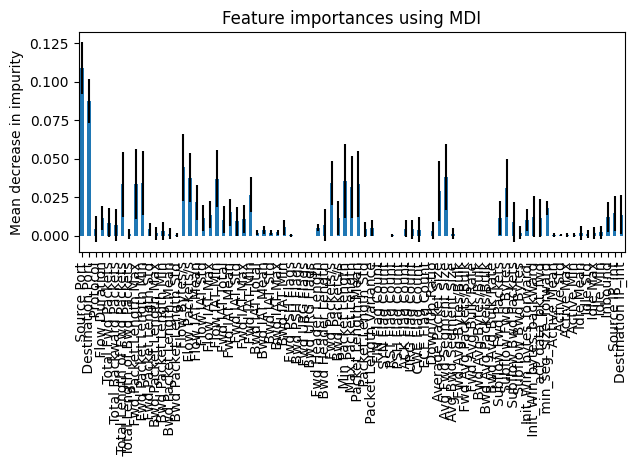

In [46]:
from matplotlib import pyplot as plt

std = np.std([tree.feature_importances_ for tree in selector.estimator_.estimators_], axis=0)
rf_importances = pd.Series(selector.estimator_.feature_importances_, index=X_train_res.columns)
fig, ax = plt.subplots()

rf_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [47]:
X_new.to_csv((save_dir + '/x.csv'), index = False)
y_train_res.to_csv((save_dir + '/y.csv'), index = False)

In [48]:
X_test_new.to_csv((save_dir + '/x_test.csv'), index = False)
y_test.to_csv((save_dir + '/y_test.csv'), index = False)

# Build Models

In [49]:
# imports needed for both models
from sklearn.metrics import f1_score, accuracy_score as accuracy
from sklearn.model_selection import GridSearchCV

In [50]:
from codecarbon import EmissionsTracker

tracker = EmissionsTracker(project_name = "detect_ddos_with_ml")

[codecarbon INFO @ 04:08:45] [setup] RAM Tracking...
[codecarbon INFO @ 04:08:45] [setup] GPU Tracking...
[codecarbon INFO @ 04:08:45] No GPU found.
[codecarbon INFO @ 04:08:45] [setup] CPU Tracking...
[codecarbon WARNING @ 04:08:45] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 04:08:46] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 04:08:46] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 04:08:46] >>> Tracker's metadata:
[codecarbon INFO @ 04:08:46]   Platform system: Linux-6.1.58+-x86_64-with-glibc2.35
[codecarbon INFO @ 04:08:46]   Python version: 3.10.12
[codecarbon INFO @ 04:08:46]   CodeCarbon version: 2.3.5
[codecarbon INFO @ 04:08:46]   Available RAM : 12.675 GB
[codecarbon INFO @ 04:08:46]   CPU count: 2
[codecarbon INFO @ 04:08:46]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 04:08:46]   GPU count: None
[codec

## Random Forest
**Values removed from param grid:**
*   n_estimators:
   *   100 - overfitting.
*   max_depth:
   *   None - overfitting.
   *   20 - overfitting.
   *   10 - overfitting.
*   max_features:
   *   'sqrt' - overfitting.
   *   'log2' - overfitting.

**Observations/Notes:**

In [67]:
# build random forest classifier model
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(class_weight = 'balanced', n_jobs = -1, random_state = 42)

# grid of parameters to search through when performing cross validation
rf_params = {
    'n_estimators' : [200, 500],
    'max_depth' : list(range(8,11,1)),
    'min_samples_leaf' : [1, 5, 10],
    'min_samples_split' : [2, 5, 10],
    'max_features' : [0.2, 0.5, 0.75]
}

# tests all permutations of the parameters outline in rf_params, returns the best performing model
rf_model = GridSearchCV(estimator = rf,
                        param_grid = rf_params,
                        scoring = ["accuracy", "f1_weighted"],
                        refit = "f1_weighted",
                        cv = 5,
                        verbose = 3,
                        return_train_score = True,
                        n_jobs = 1)

### Train Random Forest

In [68]:
tracker.start_task("train rf")

try:
  # train model
  rf_model.fit(X_new, y_train_res)
finally:
  rf_emissions = tracker.stop_task("train rf")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END max_depth=5, max_features=0.5, min_samples_leaf=5, min_samples_split=5, n_estimators=200; accuracy: (train=0.537, test=0.528) f1_weighted: (train=0.511, test=0.501) total time=  13.3s
[CV 2/5] END max_depth=5, max_features=0.5, min_samples_leaf=5, min_samples_split=5, n_estimators=200; accuracy: (train=0.553, test=0.549) f1_weighted: (train=0.538, test=0.533) total time=  11.2s


[codecarbon INFO @ 04:31:05] Energy consumed for RAM : 0.001208 kWh. RAM Power : 4.753044605255127 W
[codecarbon INFO @ 04:31:05] Energy consumed for all CPUs : 0.010803 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:31:05] 0.012011 kWh of electricity used since the beginning.


KeyboardInterrupt: 

In [60]:
print(f'Emissions: {rf_emissions.emissions * 1_000} g CO₂')

Emissions: 2.461909356658394 g CO₂


In [ ]:
# training results
rf_train = rf_model.predict(X_new)

# displays the best model produced in training as well as its' hyperparameters and f1 score
print(f'Training Result:\n Best Model: {rf_model.best_estimator_}\n Best Parameters: {rf_model.best_params_}\n F1 Score: {rf_model.best_score_}')

# evaluate the models performance and display scores
print(f'Random Forest (TRAINING):\n accuracy: {accuracy(y_train_res, rf_train):f}\n f1 score: {f1_score(y_train_res, rf_train, average="weighted"):f}')

Emissions: EmissionsData(timestamp='2024-05-01T11:12:39', project_name='detect_ddos_with_ml', run_id='e94b2bbc-35d4-4cdb-b920-96a42c51397b', duration=1890.4378867149353, emissions=0.022877917993910837, emissions_rate=1.2101937477091048e-05, cpu_power=120.0, gpu_power=0.0, ram_power=4.753043174743652, cpu_energy=0.0630143977244695, gpu_energy=0, ram_energy=0.0024959145582030594, energy_consumed=0.06551031228267255, country_name='United States', country_iso_code='USA', region='nevada', cloud_provider='', cloud_region='', os='Linux-6.1.58+-x86_64-with-glibc2.35', python_version='3.10.12', codecarbon_version='2.3.5', cpu_count=2, cpu_model='AMD EPYC 7B12', gpu_count=None, gpu_model=None, longitude=-115.1164, latitude=36.1685, ram_total_size=12.674781799316406, tracking_mode='machine', on_cloud='N', pue=1.0) kg CO₂
Training Result:
 Best Model: RandomForestClassifier(class_weight='balanced', max_depth=5, max_features=0.5,
                       min_samples_leaf=10, n_estimators=500, n_jobs=

### Test Random Forest

In [ ]:
# make predictions on test data
rf_test = rf_model.predict(X_test[X_new.columns])

# evaluate the models performance and display scores
print(f'Random Forest (TESTING):\n accuracy: {accuracy(y_test, rf_test):f}\n f1 score: {f1_score(y_test, rf_test, average="weighted"):f}')

Random Forest (TESTING):
 accuracy: 0.819923
 f1 score: 0.841668


### Export Model

In [ ]:
# uses joblib to serialise trained random forest model
SaveToFile(save_data = rf_model, save_fpath = (save_dir + "/random_forest.joblib"), skip_prompt = True)

SUCCESS: saved to '/content/drive/MyDrive/Colab Notebooks/COMP6002_Group10_Data/Exports_01-05-2024/random_forest.joblib'.


## Neural Network
Recommend running this section in a runtime with GPU enabled.

In [ ]:
# load in previously saved training data
X_new = pd.read_csv((save_dir + '/x.csv'), dtype = np.float64)
y_train_res = pd.read_csv((save_dir + '/y.csv'))

### NN Setup
Import and install required libraries, sets some initial values.

In [ ]:
# import PyTorch and confirm version
import torch
from torch import nn

print(f"Using PyTorch version: {torch.__version__}")

# check the availability of and set the device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device.")

torch.manual_seed(0)
torch.cuda.manual_seed(0)

Using PyTorch version: 2.2.1+cu121
Using cuda device.


In [ ]:
# probbaly need to use something other than a tensor here? it does not like the target variable being an object.

# convert data to tensors
X_train_t = torch.from_numpy(X_new.to_numpy())
y_train_t = torch.from_numpy(y_train_res.to_numpy())

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [ ]:
# install Skorch, providing a wrapper for using PyTorch with Sklearn
!pip install skorch

# import Skorch and confirm version
from skorch import __version__ as skorch_version

print(f"Using Skorch version: {skorch_version}")

### Define Neural Network
Currently using a Multilayer Perceptron (MLP), consider swapping to a hybrid model of a MLP and Convolutional Neural Network (CNN) later.

In [ ]:
class NN_MLP(nn.Module):
  """Class that defines a multilayer perceptron model."""
  def __init__(self, input_size, hidden_size, output_size):
    """
    Construct a new NN_MLP object.

    Parameters:
      input_size (int): number of neurons in the input layer, should be equal to the number of features in the data.
      hidden_size (int): number of neurons in each hidden layer.
      output_size (int): number of neurons in the output layer, should be equal to the number of possible classes.
    Returns:
      : no value returned.
    """
    super(NN_MLP, self).__init__()
    # layers
    self.h1 = nn.Linear(input_size, hidden_size)
    self.h2 = nn.Linear(hidden_size, hidden_size)
    self.output = nn.Linear(hidden_size, output_size)
    # activation functions
    self.relu = nn.ReLU()
    self.softmax = nn.Softmax(dim = 1)

  def forward(self, X):
    """
    Parameters:
      X (Any): features to make prediction on.
    Returns:
      Any: predicted value.
    """
    out = self.h1(X)
    out = self.relu(out)
    out = self.h2(out)
    out = self.relu(out)
    out = self.output(out)
    out = self.softmax(out)

    return out

### Define Parameters and Instantiate

In [ ]:
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping

#optimizer = ""
input_neurons = int(X_train_t.shape[1])
output_neurons = int(y_train_res.iloc[:, 0].unique().size)

# formulas for determining hidden layer sizes
hidden_1 = int((input_neurons * (2/3)) + output_neurons)
hidden_2 = int(X_train_t.shape[0] // (2 * (input_neurons + output_neurons)))

# early stop callback
early_stop = EarlyStopping(
    monitor = 'f1_weighted',
    lower_is_better = False,
    patience = 5,
    load_best = True
)

# instantiate neural network
nn_estimator = NeuralNetClassifier(
    module = NN_MLP,
    module__input_size = input_neurons,
    module__output_size = output_neurons,
    lr = 0.01,
    max_epochs = 20,
    train_split = None,
    callbacks = [early_stop],
    verbose = 0,
    device = device
)

# parameters for grid search
nn_params = {
    'lr' : [0.01, 3e-3],
    'module__hidden_size' : [hidden_1, hidden_2]
}

nn_model = GridSearchCV(
    estimator = nn_estimator,
    param_grid = nn_params,
    scoring = ["accuracy", "f1_weighted"],
    refit = "f1_weighted",
    cv = 5,
    verbose = 3,
    return_train_score = True,
    n_jobs = 1
)

### Train Neural Network

In [ ]:
tracker.start_task("train nn")

try:
  # train the neural network
  nn_model.fit(X_train_t, y_train_t)
finally:
  nn_emissions = tracker.stop_task("train nn")

In [ ]:
print(f'Emissions: {nn_emissions} kg CO₂')

### Export Neural Network

In [ ]:
SaveNN(nn_save = nn_model, nn_fpath = (save_dir + '/neural_network.pkl'), skip_prompt = True)